In [1]:
# Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import argparse
import numpy as np
import os
from tqdm.auto import tqdm
from copy import deepcopy
from mlp_numpy import MLP
from modules import CrossEntropyModule
import cifar10_utils
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from cifar10_utils import get_cifar10, get_dataloader
from modules import LinearModule, RELUModule, SoftMaxModule, CrossEntropyModule
from mlp_numpy import MLP

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

save_folder = 'results'

In [2]:
def load_model_parameters(model, load_path):
    """
    Load the model parameters from numpy arrays.

    Args:
        model: An instance of 'MLP', the model to load parameters into.
        load_path: Path to load the model parameters from.
    """
    params = np.load(load_path)
    for param_name in params.files:
        if 'w' in param_name:
            layer_index = int(param_name.split('_')[1])
            model.layers[layer_index].w = params[param_name]
        elif 'b' in param_name:
            layer_index = int(param_name.split('_')[1])
            model.layers[layer_index].b = params[param_name]


In [5]:
def save_plot_path(batch_size, epochs, learning_rate, hidden_dims):
    hidden_dims_str = '_'.join(str(dim) for dim in hidden_dims)
    return f"batch_{batch_size}_epochs_{epochs}_lr_{learning_rate}_hidden_{hidden_dims_str}.png"


In [ ]:
def plot_loss_curve(logging_dict, save_path=None, batch_size=128, epoch=10, learning_rate=0.1, hidden_dim=[128]):
    """
    Plots the training loss curve, validation accuracy curve, and training accuracy curve.

    Args:
    logging_dict: A dictionary containing logging information.
    save_path: (optional) Path to save the plot. If None, the plot will not be saved.
    """
    train_losses = logging_dict.get('train_losses', [])
    val_accuracies = logging_dict.get('val_accuracies', [])
    train_accuracies = logging_dict.get('train_accuracies', [])
    test_accuracy = logging_dict.get('test_accuracy', 0.0)
    best_val_accuracy = logging_dict.get('best_val_accuracy', 0.0)

    sns.set_style("whitegrid")

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    # Add overall title
    plt.suptitle('Grid Search Hyperparameters\n'
                 f'Batch Sizes: {batch_size}\n'
                 f'Epochs: {epoch}\n'
                 f'Learning Rates: {learning_rate}\n'
                 f'Hidden Dimensions: {hidden_dim}',
                   horizontalalignment='left')

    # Plot Training Loss Curve
    ax[0].plot(train_losses, label='Training Loss', color='teal')
    ax[0].set_xlabel('Epochs', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].set_title('Training Loss Curve', fontsize=16)
    ax[0].legend()

    # Plot Accuracy Curves
    ax[1].plot(val_accuracies, label='Validation Accuracy', color='purple')
    ax[1].plot(train_accuracies, label='Training Accuracy', color='pink')
    ax[1].set_xlabel('Epochs', fontsize=12)
    ax[1].set_ylabel('Accuracy (%)', fontsize=12)
    ax[1].set_title('Validation and Training Accuracy Curve', fontsize=16)  
    ax[1].set_ylim(np.min(np.array(train_accuracies))-10, np.max(np.array(val_accuracies))+10)
    ax[1].legend(fontsize=12)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Add spacing for the suptitle

    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [11]:
def plot_val_accuracies_grid(results, title, save_path,num_plot=81):

    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1,num_plot+1, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)
    #flatten axes
    axes = axes.flatten()
    
    # Plot validation accuracies for different learning rates
    for i in range(num_plot):
        for j in range(num_plot):
            result = results[j]
            accuracies = result['val_accuracy']
            batch_size = result['batch_size']
            lr = result['lr']

            axes[i].plot(accuracies, accuracies, label=f'Batch Size={batch_size}, LR={lr}')
            axes[i].set_title(f'Batch Size={batch_size}, LR={lr}')
            axes[i].set_xlabel('Iteration')
            axes[i].set_ylabel('Validation Accuracy')


    axes[num_plot+1].legend(loc='center', fontsize=20)
    axes[num_plot+1].axis('off')  # Hide axes
    plt.show()

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Add spacing for the suptitle

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

plot_val_accuracies_grid(results2, title, save_path,num_plot=13)

In [16]:
def print_grid_search_parameters(default_batch_size, default_lr, default_hidden_dims, default_epochs):
    print("--------------------------------------------------")
    print("Grid Search Parameters:")
    print(f"Batch size: {default_batch_size}")
    print(f"Learning rate: {default_lr}")
    print(f"Hidden dimensions: {default_hidden_dims}")
    print(f"Number of epochs: {default_epochs}")
    print("--------------------------------------------------")
def print_results_of_round(val_accuracy, test_accuracy, train_accuracy, batch_size, lr, hidden_dims, epochs):
    print("--------------------------------------------------")
    print("Results of this round:")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Test accuracy: {test_accuracy:.2f}%")
    print(f"Train accuracy: {train_accuracy:.2f}%")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {lr}")
    print(f"Hidden dimensions: {hidden_dims}")
    print(f"Number of epochs: {epochs}")
    print("--------------------------------------------------")
def print_best_parameters(best_accuracy, best_batch_size, best_lr, best_hidden_dims, best_epochs):
    print("Best parameters:")
    print(f"Best accuracy: {best_accuracy:.2f}%")
    print(f"Best batch size: {best_batch_size}")
    print(f"Best learning rate: {best_lr}")
    print(f"Best hidden dimensions: {best_hidden_dims}")
    print(f"Best number of epochs: {best_epochs}")

In [2]:
# Import and merege the results from the pickle files
import pickle

# Load results from the pickle file
save_folder = 'results\\third'
with open(os.path.join(save_folder, 'results.pkl'), 'rb') as f:
    loaded_results1 = pickle.load(f)

# Load results from the pickle file
save_folder = 'results\\forth'
with open(os.path.join(save_folder, 'results.pkl'), 'rb') as f:
    loaded_results2 = pickle.load(f)

# Load results from the pickle file
save_folder = 'results\\fifth'
with open(os.path.join(save_folder, 'results.pkl'), 'rb') as f:
    loaded_results3 = pickle.load(f)

loaded_results = loaded_results1 + loaded_results2 + loaded_results3
results = loaded_results
# print exploreratory details of the fata set
print("Number of results: ", len(loaded_results))
print("First result: ", loaded_results[0])
print("Keys of the results: ", loaded_results[0].keys())




Number of results:  221
First result:  {'batch_size': 16, 'lr': 2, 'hidden_dims': [128], 'epochs': 10, 'val_accuracy': [10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999, 10.639999999999999], 'test_accuracy': 10.0, 'train_accuracy': [9.930654338549076, 9.92843172119488, 9.926209103840684, 9.92843172119488, 9.92843172119488, 9.930654338549076, 9.92843172119488, 9.930654338549076, 9.92843172119488, 9.930654338549076]}
Keys of the results:  dict_keys(['batch_size', 'lr', 'hidden_dims', 'epochs', 'val_accuracy', 'test_accuracy', 'train_accuracy'])


In [3]:
def print_results_summary(results):
    print("Summary of results:")
    print("--------------------------------------------------")
    print(f"Total number of configurations: {len(results)}")
    print("")

    # Extract lr and batch_size along with accuracies
    lr_values = [result['lr'] for result in results]
    batch_size_values = [result['batch_size'] for result in results]
    val_accuracies = [np.mean(result['val_accuracy']) for result in results]
    test_accuracies = [result['test_accuracy'] for result in results]
    train_accuracies = [np.mean(result['train_accuracy']) for result in results]

    # Calculate statistics for accuracies
    val_mean = np.mean(val_accuracies)
    val_max_idx = np.argmax(val_accuracies)
    val_min_idx = np.argmin(val_accuracies)
    val_max = val_accuracies[val_max_idx]
    val_min = val_accuracies[val_min_idx]
    val_max_lr = lr_values[val_max_idx]
    val_max_batch_size = batch_size_values[val_max_idx]
    val_min_lr = lr_values[val_min_idx]
    val_min_batch_size = batch_size_values[val_min_idx]

    test_mean = np.mean(test_accuracies)
    test_max_idx = np.argmax(test_accuracies)
    test_min_idx = np.argmin(test_accuracies)
    test_max = test_accuracies[test_max_idx]
    test_min = test_accuracies[test_min_idx]
    test_max_lr = lr_values[test_max_idx]
    test_max_batch_size = batch_size_values[test_max_idx]
    test_min_lr = lr_values[test_min_idx]
    test_min_batch_size = batch_size_values[test_min_idx]

    train_mean = np.mean(train_accuracies)
    train_max_idx = np.argmax(train_accuracies)
    train_min_idx = np.argmin(train_accuracies)
    train_max = train_accuracies[train_max_idx]
    train_min = train_accuracies[train_min_idx]
    train_max_lr = lr_values[train_max_idx]
    train_max_batch_size = batch_size_values[train_max_idx]
    train_min_lr = lr_values[train_min_idx]
    train_min_batch_size = batch_size_values[train_min_idx]

    # Print results
    print("Validation Accuracy:")
    print(f"  Mean: {val_mean:.2f}%")
    print(f"  Maximum: {val_max:.2f}% (LR: {val_max_lr}, Batch Size: {val_max_batch_size})")
    print(f"  Minimum: {val_min:.2f}% (LR: {val_min_lr}, Batch Size: {val_min_batch_size})")
    print("")

    print("Test Accuracy:")
    print(f"  Mean: {test_mean:.2f}%")
    print(f"  Maximum: {test_max:.2f}% (LR: {test_max_lr}, Batch Size: {test_max_batch_size})")
    print(f"  Minimum: {test_min:.2f}% (LR: {test_min_lr}, Batch Size: {test_min_batch_size})")
    print("")

    print("Train Accuracy:")
    print(f"  Mean: {train_mean:.2f}%")
    print(f"  Maximum: {train_max:.2f}% (LR: {train_max_lr}, Batch Size: {train_max_batch_size})")
    print(f"  Minimum: {train_min:.2f}% (LR: {train_min_lr}, Batch Size: {train_min_batch_size})")
    print("--------------------------------------------------")


print_results_summary(loaded_results)


Summary of results:
--------------------------------------------------
Total number of configurations: 221

Validation Accuracy:
  Mean: 23.46%
  Maximum: 49.60% (LR: 0.001, Batch Size: 2)
  Minimum: 9.42% (LR: 1, Batch Size: 16)

Test Accuracy:
  Mean: 25.86%
  Maximum: 51.57% (LR: 0.05, Batch Size: 128)
  Minimum: 9.96% (LR: 1, Batch Size: 1)

Train Accuracy:
  Mean: 24.80%
  Maximum: 58.62% (LR: 0.001, Batch Size: 2)
  Minimum: 9.80% (LR: 1e-07, Batch Size: 16384)
--------------------------------------------------


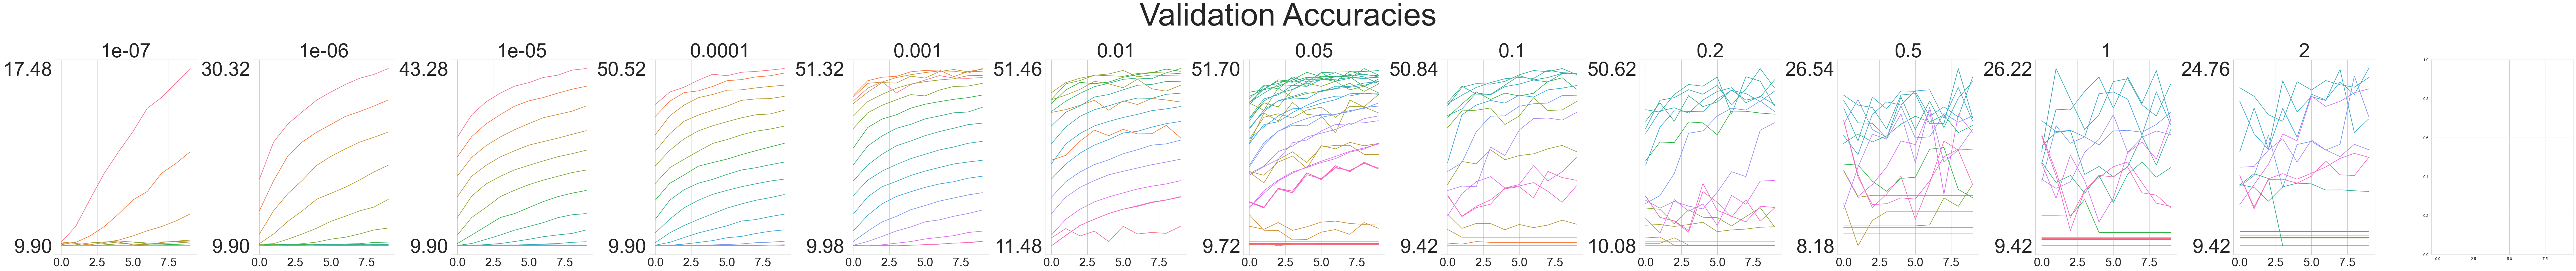

In [47]:
# Validation

def plot_val_accuracies_grid(results, title, save_path, num_lrs=13):
    sns.set_style("whitegrid")

    # Unique learning rates and batch sizes
    learning_rates = sorted(set(result['lr'] for result in results))
    batch_sizes = sorted(set(result['batch_size'] for result in results))

    # Create a consistent color palette
    colors = sns.color_palette("husl", len(batch_sizes))

    fig, axes = plt.subplots(1, num_lrs, figsize=(7 * num_lrs, 10), sharex=True)
    fig.suptitle(title, fontsize=80)

    #axes[0].set_ylabel('Validation Accuracy', fontsize=18)
    
    # Plot validation accuracies for different learning rates
    for lr_idx, lr in enumerate(learning_rates):
        ax = axes[lr_idx]
        max_acc = -float('inf')
        min_acc = float('inf')
        for bs_idx, batch_size in enumerate(batch_sizes):
            for result in results:
                if result['lr'] == lr and result['batch_size'] == batch_size:
                    accuracies = result['val_accuracy']
                    ax.plot(range(len(accuracies)), accuracies, label=f'Batch Size={batch_size}', color=colors[bs_idx])
                    max_acc = max(max_acc, max(accuracies))
                    min_acc = min(min_acc, min(accuracies))
                    
         # Format the title to display in scientific notation without trailing zeros
        formatted_lr = "{:.2e}".format(lr).replace("+", "")  # Remove the unnecessary '+'
        ax.set_title(f'{lr}', fontsize=50)  # Scientific notation title
        

        # Set the y-ticks to only show min and max values
        ax.set_yticks([min_acc, max_acc])
        ax.set_yticklabels([f'{min_acc:.2f}', f'{max_acc:.2f}'])

        # Adjust the font size of y-tick labels
        ax.tick_params(axis='y', labelsize=50) 
        ax.tick_params(axis='x', labelsize=30)


    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Add spacing for the suptitle

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

# Example usage
# loaded_results = [...]  # Your data here
save_path = "val_accuracies_grid.png"
plot_val_accuracies_grid(loaded_results, "Validation Accuracies", save_path)


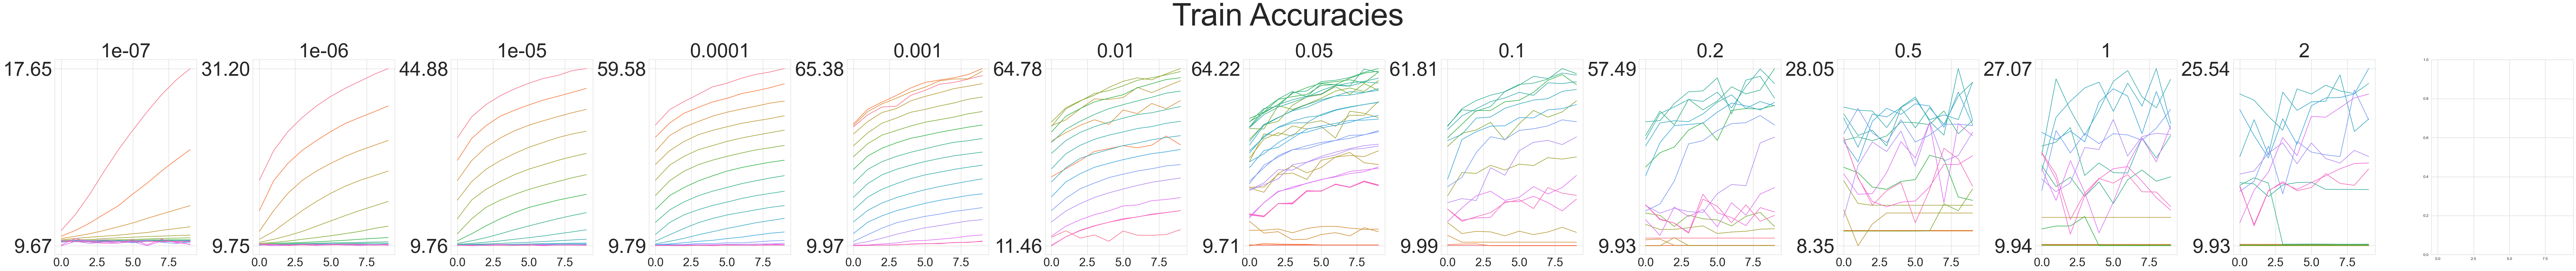

In [46]:
# Train

def plot_val_accuracies_grid(results, title, save_path, num_lrs=13):
    sns.set_style("whitegrid")

    # Unique learning rates and batch sizes
    learning_rates = sorted(set(result['lr'] for result in results))
    batch_sizes = sorted(set(result['batch_size'] for result in results))

    # Create a consistent color palette
    colors = sns.color_palette("husl", len(batch_sizes))

    fig, axes = plt.subplots(1, num_lrs, figsize=(7 * num_lrs, 10), sharex=True)
    fig.suptitle(title, fontsize=80)

    #axes[0].set_ylabel('Validation Accuracy', fontsize=18)
    
    # Plot validation accuracies for different learning rates
    for lr_idx, lr in enumerate(learning_rates):
        ax = axes[lr_idx]
        max_acc = -float('inf')
        min_acc = float('inf')
        for bs_idx, batch_size in enumerate(batch_sizes):
            for result in results:
                if result['lr'] == lr and result['batch_size'] == batch_size:
                    accuracies = result['train_accuracy']
                    ax.plot(range(len(accuracies)), accuracies, label=f'Batch Size={batch_size}', color=colors[bs_idx])
                    max_acc = max(max_acc, max(accuracies))
                    min_acc = min(min_acc, min(accuracies))
                    
         # Format the title to display in scientific notation without trailing zeros
        formatted_lr = "{:.2e}".format(lr).replace("+", "")  # Remove the unnecessary '+'
        ax.set_title(f'{lr}', fontsize=50)  # Scientific notation title
        

        # Set the y-ticks to only show min and max values
        ax.set_yticks([min_acc, max_acc])
        ax.set_yticklabels([f'{min_acc:.2f}', f'{max_acc:.2f}'])

        # Adjust the font size of y-tick labels
        ax.tick_params(axis='y', labelsize=50) 
        ax.tick_params(axis='x', labelsize=30)


    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Add spacing for the suptitle

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

# Example usage
# loaded_results = [...]  # Your data here
save_path = "train_accuracies_grid.png"
plot_val_accuracies_grid(loaded_results, "Train Accuracies", save_path)


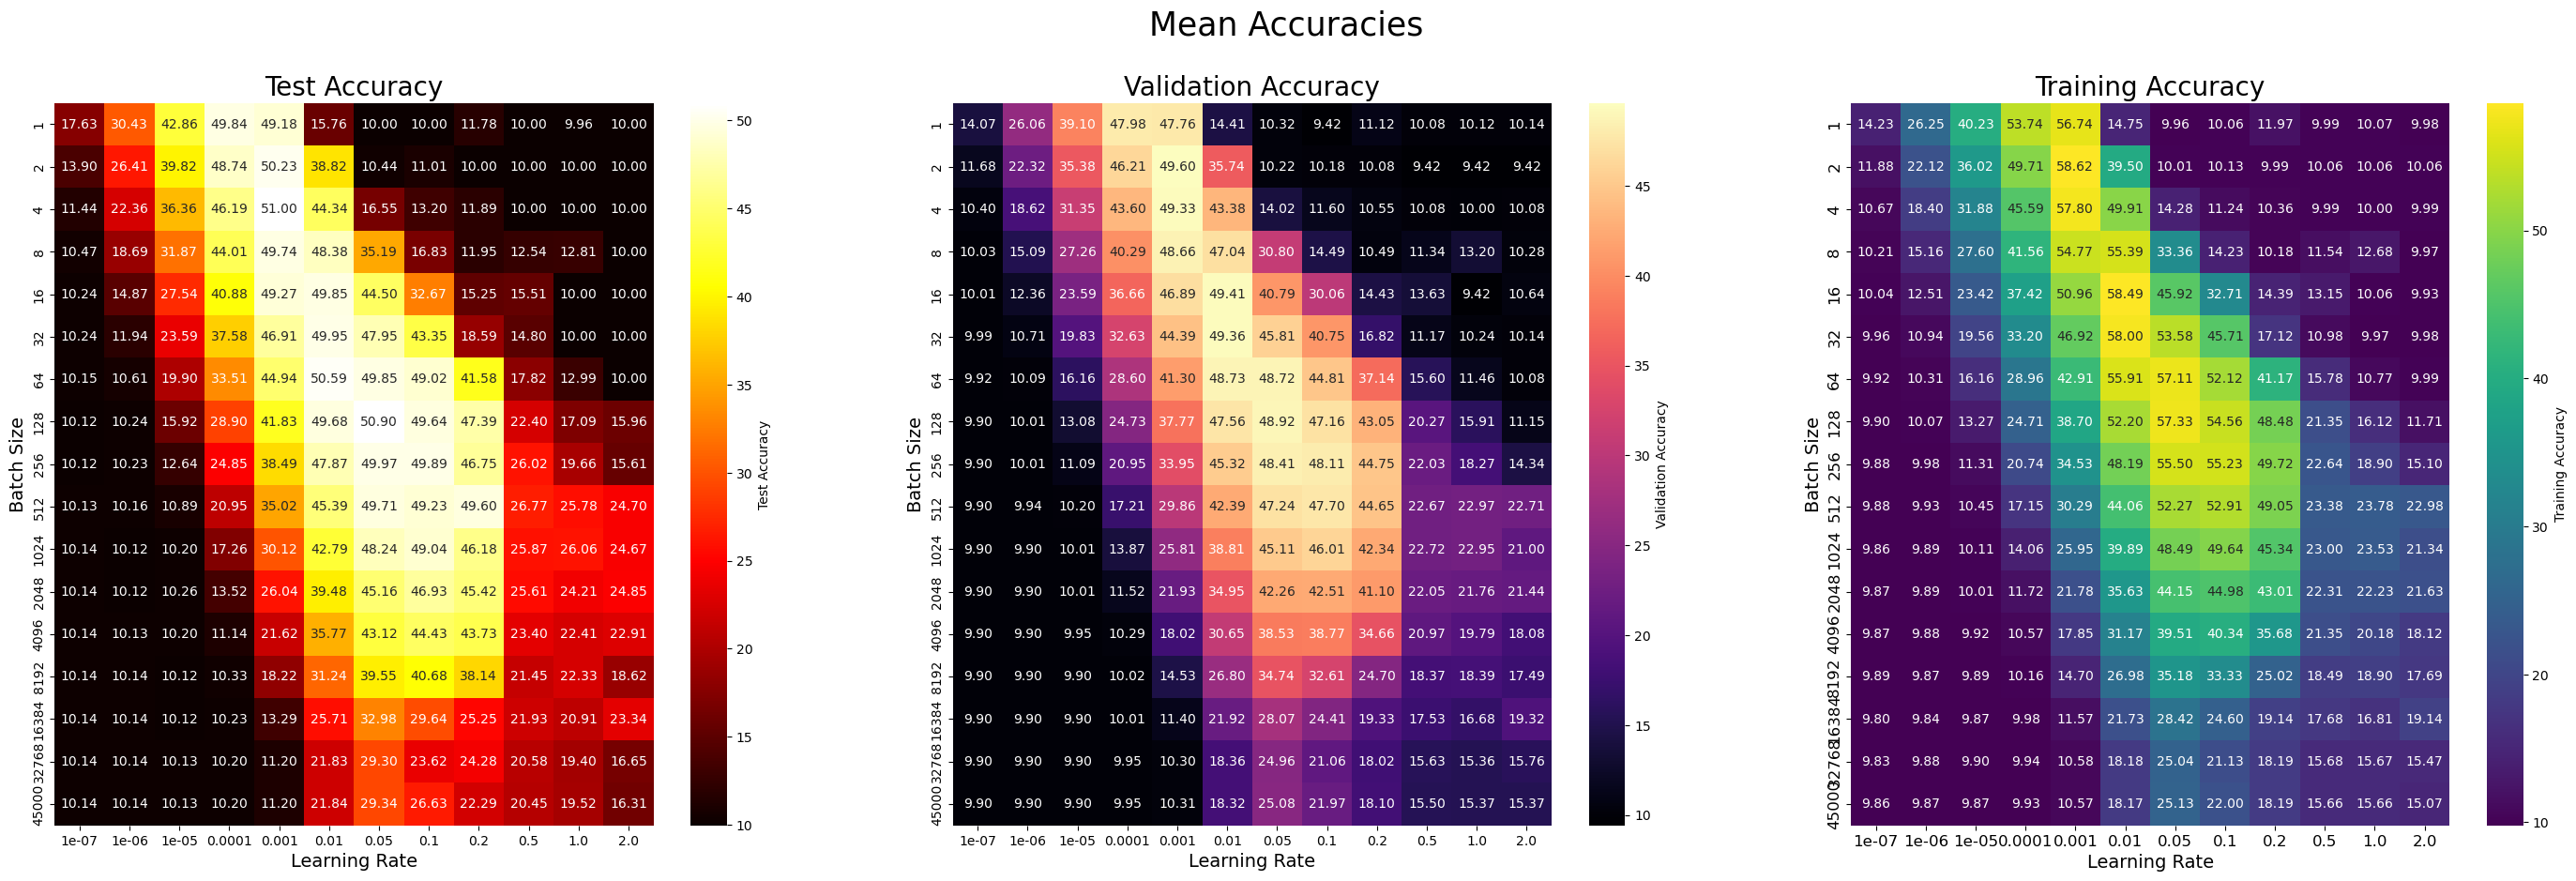

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_val_accuracy_heatmap(results, title, save_path=None):
    # Extract unique learning rates and batch sizes
    learning_rates = sorted(set(result['lr'] for result in results))
    batch_sizes = sorted(set(result['batch_size'] for result in results))
    
    # Create a DataFrame to hold the mean validation accuracies
    heatmap_data_train = pd.DataFrame(index=batch_sizes, columns=learning_rates, dtype=float)
    heatmap_data_val = pd.DataFrame(index=batch_sizes, columns=learning_rates, dtype=float)
    heatmap_data_test = pd.DataFrame(index=batch_sizes, columns=learning_rates, dtype=float)

    # Populate the DataFrame with mean validation accuracies
    for lr in learning_rates:
        for bs in batch_sizes:
            val_accs = [np.mean(result['val_accuracy']) for result in results if result['lr'] == lr and result['batch_size'] == bs]
            heatmap_data_val.loc[bs, lr] = np.mean(val_accs) if val_accs else np.nan
            train_accs = [np.mean(result['train_accuracy']) for result in results if result['lr'] == lr and result['batch_size'] == bs]
            heatmap_data_train.loc[bs, lr] = np.mean(train_accs) if train_accs else np.nan
            test_accs = [result['test_accuracy'] for result in results if result['lr'] == lr and result['batch_size'] == bs]
            heatmap_data_test.loc[bs, lr] = np.mean(test_accs) if test_accs else np.nan

    #plots the 3 heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(35, 10))
    fig.suptitle(title, fontsize=25)

        # Plot the heatmap for test accuracy
    sns.heatmap(heatmap_data_test, fmt=".2f",annot=True, cbar_kws={'label': 'Test Accuracy'}, ax=axes[0], cmap='hot')
    axes[0].set_title('Test Accuracy', fontsize=20)
    axes[0].set_xlabel('Learning Rate', fontsize=14)
    axes[0].set_ylabel('Batch Size', fontsize=14)


    # Plot the heatmap for validation accuracy
    sns.heatmap(heatmap_data_val, fmt=".2f", cmap="magma", annot=True, cbar_kws={'label': 'Validation Accuracy'}, ax=axes[1])
    axes[1].set_title('Validation Accuracy', fontsize=20)
    axes[1].set_xlabel('Learning Rate', fontsize=14)
    axes[1].set_ylabel('Batch Size', fontsize=14)

    # Plot the heatmap for training accuracy
    sns.heatmap(heatmap_data_train, fmt=".2f", cmap="viridis", annot=True, cbar_kws={'label': 'Training Accuracy'}, ax=axes[2])
    axes[2].set_title('Training Accuracy', fontsize=20)
    axes[2].set_xlabel('Learning Rate', fontsize=14)
    axes[2].set_ylabel('Batch Size', fontsize=14)


    # make the numbering bigger
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Example usage
save_path = "val_accuracy_heatmap.png"
plot_val_accuracy_heatmap(loaded_results, "Mean Accuracies", save_path)


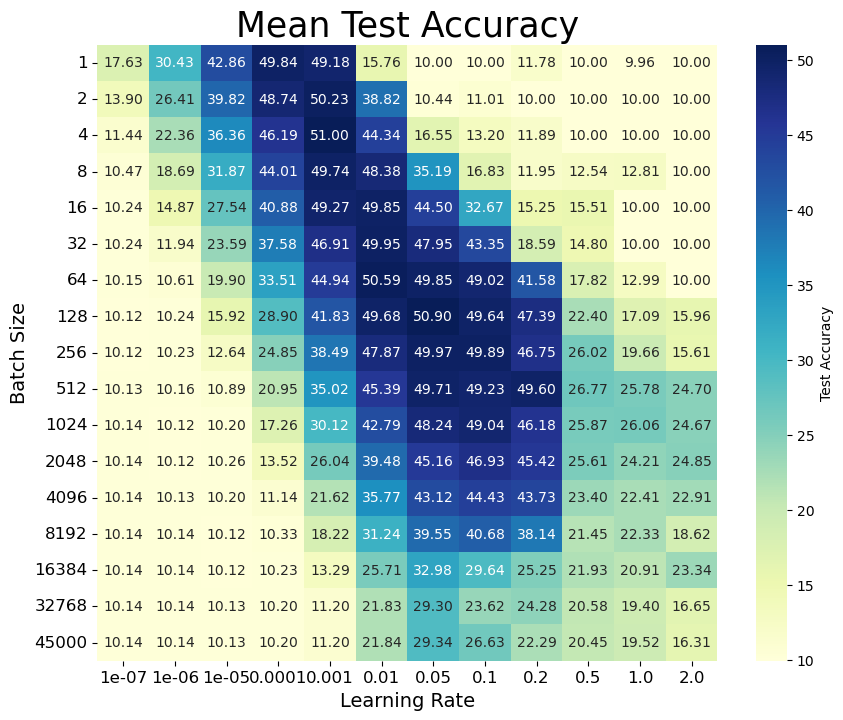

In [ ]:


def plot_val_accuracy_heatmap(results, title, save_path=None):

    # Extract unique learning rates and batch sizes
    learning_rates = sorted(set(result['lr'] for result in results))
    batch_sizes = sorted(set(result['batch_size'] for result in results))
    
    # Create a DataFrame to hold the mean validation accuracies
    heatmap_data = pd.DataFrame(index=batch_sizes, columns=learning_rates, dtype=float)

    # Populate the DataFrame with mean validation accuracies
    for lr in learning_rates:
        for bs in batch_sizes:
            val_accs = [np.mean(result['test_accuracy']) for result in results if result['lr'] == lr and result['batch_size'] == bs]
            heatmap_data.loc[bs, lr] = np.mean(val_accs) if val_accs else np.nan

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, fmt=".2f", annot=True,  cmap="YlGnBu", cbar_kws={'label': 'Test Accuracy'})
    plt.title(title, fontsize=25)
    plt.xlabel('Learning Rate', fontsize=14)
    plt.ylabel('Batch Size', fontsize=14)

    # make the numbering bigger
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

# Example usage
save_path = "val_accuracy_heatmap.png"
plot_val_accuracy_heatmap(loaded_results, "Mean Test Accuracy", save_path)
